- https://explosion.ai/blog/deep-learning-formula-nlp
- https://github.com/explosion/spaCy/tree/master/examples/keras_parikh_entailment
- https://quid.com/feed/how-quid-uses-deep-learning-with-small-data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.feature_selection import SelectFpr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter, defaultdict
from textacy.similarity import word2vec, word_movers
import spacy
import re
import string
import gensim
import numpy as np
from numpy import dot 
from numpy.linalg import norm

In [2]:
parser = spacy.en.English()
punctuations = string.punctuation
nlp = spacy.load("en")

In [3]:
## Function for choosing majority decision over
## tagged data
def majority_decision(ratings):
    decision_sum = 0
    for r in ratings:
        if r == 'yes':
            decision_sum += 1
        elif r == 'no':
            decision_sum -= 1
    if decision_sum > 0:
        return "yes"
    else:
        return "no"
    
## Cleanup text
def clean_text(text):     
    return text.strip().lower()

In [4]:
## Load the tagged data
df = pd.read_csv("f1015046.csv")

In [5]:
## Convert data to unique excerpts and combine tags
excerpts = df['_unit_id'].unique().tolist()
output = []
for e in excerpts:
    d = {}
    sentence = df[df['_unit_id'] == e]['sentence'].tolist()[0]
    d['sentence'] = sentence
    d['is_displacement'] = majority_decision(df[df['_unit_id'] == e]['is_displacement'].tolist())
    output.append(d)
df = pd.DataFrame(output)

In [6]:
RANDOM_STATE = 42

#### Different approaches
1. Count Vectorizer approach (1-grams, 2-grams)
2. TfIDF Vectorizer
2. Sentence & word embedding approach (as features)
3. Distance of sentence from some ideal
4. Combination of predictions

In [7]:
train, test = train_test_split(df, test_size = 0.2, random_state=RANDOM_STATE)

In [8]:
is_displacement = lambda x: x == 'yes'

### 1. Simple Count Vectorizer

In [9]:
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]
    return tokens

In [12]:
def model_cv():
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    
    model = Pipeline([
            ('features', CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))),
            ('feature_select', SelectFpr()),
            ('logistic_regression', GridSearchCV(
                LogisticRegression(penalty='l2', random_state=RANDOM_STATE), param_grid))
        ])
    return model

In [13]:
cv_model = model_cv()

In [14]:
cv_model.fit(train['sentence'], train['is_displacement'])

Pipeline(steps=[('features', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        s...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0))])

In [15]:
y_predict = np.apply_along_axis(is_displacement, 0, cv_model.predict(test['sentence']))
y_true = test['is_displacement'].map(is_displacement)
print(classification_report( y_true, y_predict ))

             precision    recall  f1-score   support

      False       0.78      0.75      0.77       142
       True       0.86      0.88      0.87       252

avg / total       0.83      0.84      0.83       394



In [16]:
fpr, tpr, _ = roc_curve(y_true, y_predict)
roc_auc = auc(fpr, tpr)

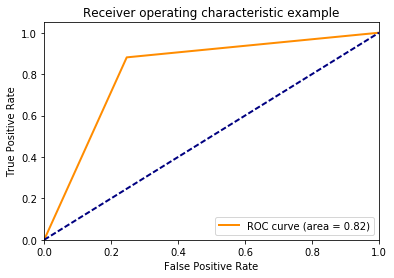

In [17]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 2. TF-IDF Vectorizer

In [18]:
def model_tfidf():
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    
    model = Pipeline([
            ('features', TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))),
            ('feature_select', SelectFpr()),
            ('logistic_regression', GridSearchCV(
                LogisticRegression(penalty='l2', random_state=RANDOM_STATE), param_grid))
        ])
    return model

In [19]:
tf_idf_model = model_tfidf()

In [20]:
tf_idf_model.fit(train['sentence'], train['is_displacement'])

Pipeline(steps=[('features', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True...     pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0))])

In [21]:
y_predict = np.apply_along_axis(is_displacement, 0, tf_idf_model.predict(test['sentence']))
y_true = test['is_displacement'].map(is_displacement)
print(classification_report( y_true, y_predict ))

             precision    recall  f1-score   support

      False       0.85      0.65      0.74       142
       True       0.83      0.94      0.88       252

avg / total       0.83      0.83      0.83       394



In [22]:
fpr, tpr, _ = roc_curve(y_true, y_predict)
roc_auc = auc(fpr, tpr)

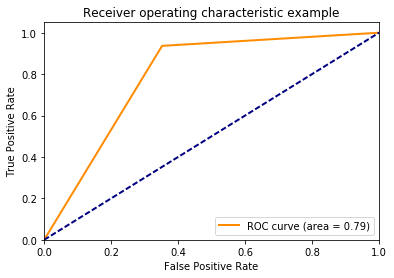

In [23]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 3. Feature & Classifier Pipeline

In [86]:
# Customer Transformer for creating pipeline of classifiers and predicting probabilities
class ProbaExtractor(TransformerMixin):
    def __init__(self, classifiers):
        self.classifiers = classifiers
        
    def fit(self, *args, **kwargs):
        for cl in self.classifiers:
            cl.fit(*args, **kwargs)
        return self
    
    def transform(self, X, **transform_params):
        return np.concatenate([cl.predict_proba(X) for cl in self.classifiers], axis=1)

In [25]:
# Customer Transformer to extract the sentence embedding as an average of word embeddings (using word2vec)
class MeanEmbeddingVectorizer(TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = (300,)

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([w.vector for w in nlp(sentence)]
                    or [np.zeros(self.dim)], axis=0)
            for sentence in X
        ])

In [53]:
# Customer Transformer to find cosine difference between sentence vector & average true sentence vector
cosine = lambda v1, v2: dot(v1, v2) / (norm(v1) * norm(v2))

class CosDifference(TransformerMixin):
    def __init__(self, nlp, sentences):
        self.nlp = nlp
        self.true_mean = np.mean(np.array([
            np.mean([w.vector for w in nlp(sentence)]
                    or [np.zeros(self.dim)], axis=0)
            for sentence in sentences
        ]), axis=0)
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = (300,)

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array(
            [cosine(np.mean([w.vector for w in nlp(sentence)], axis=0), self.true_mean)
             for sentence in X]).reshape(X.shape[0], 1)

In [97]:
# Transformer for getting distribution of punctuation
class Punctuation(TransformerMixin):
    def __init__(self, punctuations):
        self.punctuations = punctuations
        
    def fit(self, *args, **kwargs):
        return self
    
    def transform(self, X, **transform_params):
        return np.array(
            [
              [sentence.count(p) for p in self.punctuations] for sentence in X
            ])

In [113]:
def capitals_fractions(sentence):
    words = sentence.split(" ")
    num_words = len(words)
    # Total fraction of capitalized words
    one_grams = sum([word.isupper() for word in words])
    bi_grams = 0
    for w1, w2 in zip(words, words[1:]):
        if all(w.isupper() for w in (w1, w2)):
            bi_grams += 1
    tri_grams = 0
    for w1, w2, w3 in zip(words, words[1:], words[2:]):
        if all(w.isupper() for w in (w1, w2, w3)):
            tri_grams += 1
    return np.array([one_grams, bi_grams, tri_grams]) / num_words

class Capitals(TransformerMixin):
    
    def fit(self, *args, **kwargs):
        return self
    
    def transform(self, X, **transform_params):
        return np.array([capitals_fractions(sentence) for sentence in X])

In [68]:
# Transformer for converting from sparse to dense matrix
class Densify(TransformerMixin):
    def fit(self, *args, **kwargs):
        return self
    
    def transform(self, X, **transform_params):
        return X.toarray()

In [122]:
# To do: punctuation & capital letter distribution
def get_features(true_sentences):
    return FeatureUnion([
            ('sentence_vector', MeanEmbeddingVectorizer(nlp)), #Average embedding for sentence
            ('count_vectorizer', CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))), 
            ('cos_difference', CosDifference(nlp, true_sentences)) #Cosine difference of sentence vector from average true sentence
            #('w2v_difference', ) #W2V difference of sentence from All true sentences
        ])

In [123]:
def artesenal_model(true_sentences):
    model = Pipeline([
            ('feature_union', get_features(true_sentences)),
            ('feature_selection', SelectFpr()),
            ('dense', Densify()),
            ('probas', ProbaExtractor([
                        AdaBoostClassifier(n_estimators=300),
                        ExtraTreesClassifier(n_estimators=300),
                        RandomForestClassifier(n_estimators=400),
                        LogisticRegression(),
                        BaggingClassifier(),
                        KNeighborsClassifier(),
                        GradientBoostingClassifier()
                    ])), #Need to write custom extractor
            ('polynomial', PolynomialFeatures(degree=2)),
            ('classify', LogisticRegression(C=0.5))
        ])
    return model

In [124]:
art_model = artesenal_model(train[train['is_displacement'] == 'yes']['sentence'])

In [125]:
art_model.fit(train['sentence'], train['is_displacement'])

Pipeline(steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('sentence_vector', <__main__.MeanEmbeddingVectorizer object at 0x1363394a8>), ('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', in...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [126]:
y_predict = np.apply_along_axis(is_displacement, 0, art_model.predict(test['sentence']))
y_true = test['is_displacement'].map(is_displacement)
print(classification_report( y_true, y_predict ))

             precision    recall  f1-score   support

      False       0.89      0.71      0.79       142
       True       0.85      0.95      0.90       252

avg / total       0.87      0.86      0.86       394



In [127]:
fpr, tpr, _ = roc_curve(y_true, y_predict)
roc_auc = auc(fpr, tpr)

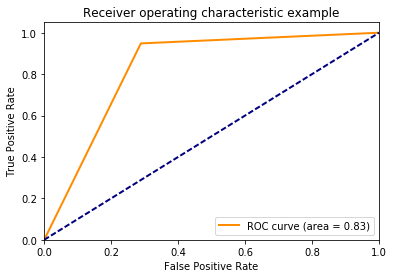

In [128]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()